В этой тетрадке я напишу практически с нуля архитектуру для детекции, а также воспользуюсь готовым решением.

Датасет содержит около 300 картинок, данные хранятся в xml в формате PascalVOC.


## Данные

Разметка находится в xmls папке, картинки в images.

In [ ]:
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
!unzip -q data.zip

--2023-12-11 13:01:11--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2023-12-11 13:01:11--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  36.61M   218MB/s    in 0.2s    

2023-12-11 13:01:12 (218 MB/s) - ‘data.zip’ saved [38392108/38392108]



# Реализуем датасет

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [ ]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
# import glob
import numpy as np
from PIL import Image
import torchvision
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from glob import glob as glob_function  # ломалось все почему-то, починилось когда функцию переименовал


Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [ ]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    filename = image_name.split("/")[-1].split(".")[0]
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()

    bboxes = []
    for member in treeroot.findall("object"):
        class_name = member.find("name").text
        xmin = int(member.find("bndbox/xmin").text)
        ymin = int(member.find("bndbox/ymin").text)
        xmax = int(member.find("bndbox/xmax").text)
        ymax = int(member.find("bndbox/ymax").text)

        label = class_dict[class_name]
        bboxes.append([xmin, ymin, xmax, ymax, label])

    return bboxes

In [ ]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob_function(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        image = Image.open(fname).convert("RGB")
        bboxes = get_xml_data(fname, self.root, self.class_dict)
        image = np.array(image)

        return self.transform(image=image, bboxes=bboxes)
    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)


    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [ ]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Готовим функции для визуализации картинок

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишем функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит сделать обратное преобразование: int, содержащий класс, в строку с названием.


In [ ]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        image = images[i].permute(1, 2, 0).numpy()
        image = (image * std) + mean
        image = np.clip(image, 0, 1)

        ax.imshow(image)

        for bbox in bboxes[i]:
            xmin, ymin, xmax, ymax, label = bbox
            label_name = train_ds.class_dict_inv[label]

            rect = Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor="r", facecolor = 'none'
            )
            ax.add_patch(rect)

            ax.text(
                xmin, ymin, f"{label_name}", color="r",
                bbox=dict(facecolor="white", alpha=0.6),
            )

    fig.tight_layout()
    plt.show()

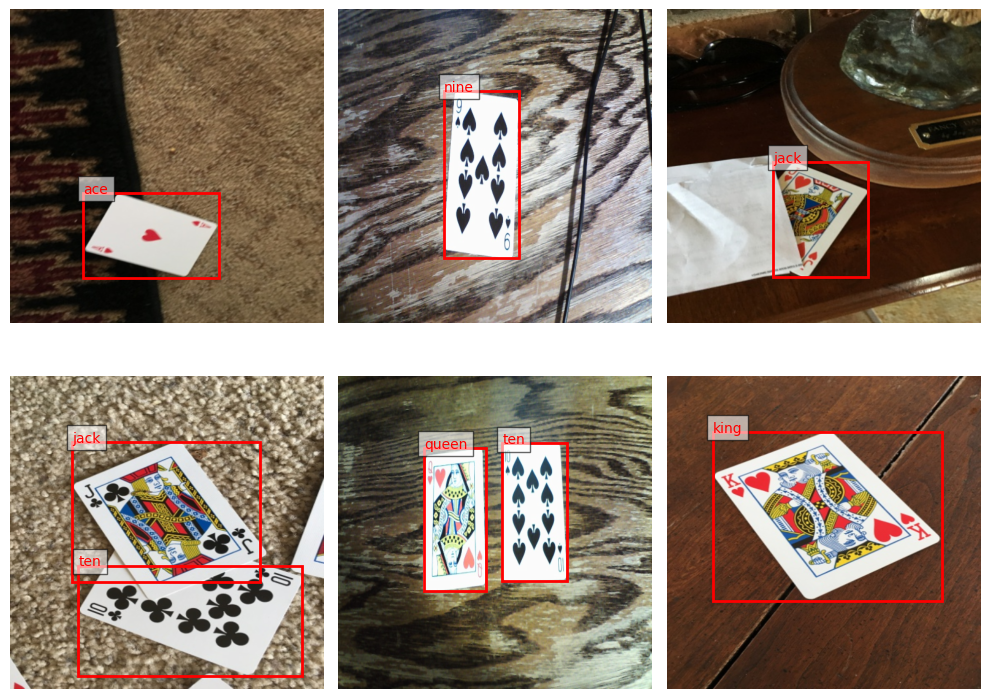

In [ ]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# DIY_YOLO

Будем реализовывать YOLO, который описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь я его немного изменю и упрощу. Буду использовать ResNet для извлечения признаков. На выходе будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## collate_fn

Нам нужно реализовать функцию collate, которая позволит настроить процесс создания батча из примеров. Эта функция будет принимать на вход список прямоугольников (bounding boxes, bbox) и генерировать тензор размером Bx16x16x6, где:

	•	B — количество примеров в батче.
	•	16x16 — размеры сетки.

В каждом “пикселе” сетки 16x16 будет 6 каналов:

	1.	Сдвиги центра bbox относительно начала клетки: Записываются в два канала (X и Y) в соответствующую клетку сетки.
	2.	Нормализованные ширина и высота bbox: Записываются в два канала (W и H).
	3.	Confidence сетки: Один канал, содержащий значение 1, если в клетке есть bbox, и 0 в противном случае.
	4.	Класс объекта: Один канал, содержащий целое число, соответствующее классу детекции, полученному из строки с названием класса.

In [ ]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))
    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        w = (xmax - xmin)
        h = (ymax - ymin)
        w_box = w / 512
        h_box = h / 512

        cx = (xmin + xmax) / 2
        cy = (ymin + ymax) / 2
        cx_idx = cx // downsample
        cy_idx = cy // downsample
        cx_box = (cx - cx_idx * downsample) / downsample
        cy_box = (cx - cy_idx * downsample) / downsample

        target[i, :, cy_idx.long(), cx_idx.long()] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

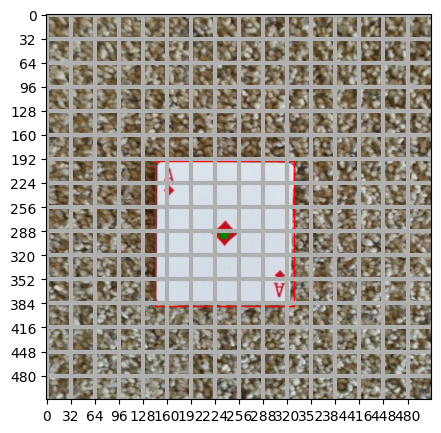

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## decode_prediction
В нашем проекте выходной тензор нейронной сети будет иметь размеры, превышающие Bx16x16x6. Это связано с тем, что мы решаем задачу классификации, где существует несколько классов объектов. Как в случае с предыдущими задачами, где целевой класс был представлен одним числом, здесь выход сети будет содержать вектор вероятностей для каждого класса. Однако теперь это происходит в двухмерном пространстве: каждая клетка из сетки 16x16 будет иметь свой вектор длины C, используемый для определения класса.

Нам необходимо реализовать функцию обратного преобразования относительно collate_fn, которая будет декодировать выходные данные нейронной сети. Функция decode_prediction должна преобразовать выход нейросети обратно в исходный набор прямоугольников (bbox) с корректными размерами, координатами и классами.

При применении decode_prediction к выходу функции collate_fn мы должны получить первоначальный набор прямоугольников с правильными классами и координатами. При применении этой же функции к выходу нейронной сети мы также должны получить набор прямоугольников с корректно определенными классами.

Основная задача функции — выполнить обратные операции, которые были заложены в collate_fn, но с учетом того, что выходной тензор сети содержит больше каналов. Если количество каналов в входном объекте равно 6, то перед нами целевой объект (target), и мы просто извлекаем записанное значение. Если же количество каналов больше 6, то перед нами выход нейросети, и мы определяем класс объекта путем нахождения argmax по соответствующим каналам.

In [ ]:
def decode_prediction(output, upsample=32, threshold = 0.2):
    # output = output['target']
    if len(output.size()) == 3:
        output = output.unsqueeze(0)


    is_target = output.size(1) == 6
    grid_size = output.size(2)

    rectangles = []

    for i in range(output.size(0)):
        for j in range(grid_size):
            for k in range(grid_size):
                confidence = 0
                if is_target:
                    # для таргета в cls идет одно число
                    cx_box, cy_box, w_box, h_box, confidence, cls = output[i, :, j, k]
                    cx_box, cy_box, w_box, h_box, confidence, cls = cx_box.item(), cy_box.item(), w_box.item(), h_box.item(), confidence.item(), cls.item()
                else:
                    # для предикта список
                    cx_box, cy_box, w_box, h_box, confidence, *cls = output[i, :, j, k]
                    confidence, cx_box, cy_box, w_box, h_box, cls = confidence.item(), cx_box.item(), cy_box.item(), w_box.item(), h_box.item(), np.array(cls).argmax().item()
                if all(val == 0 for val in [cx_box, cy_box, w_box, h_box, confidence, cls]):  # отсекаем пустые клетки
                    continue

                if confidence > threshold:
                    w = w_box * 512
                    h = h_box * 512
                    cy_idx = j
                    cx_idx = k
                    cx = upsample * (cx_box + cx_idx)
                    cy = upsample * (cy_box + cy_idx)
                    xmin = cx - w / 2
                    ymin = cy - h / 2
                    xmax = cx + w / 2
                    ymax = cy + h / 2

                    rectangles.append({'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax, 'class': cls})

    return rectangles




## Модель


In [ ]:
C =  len(set(train_ds.class_dict.values()))

class Detector(nn.Module):
    def __init__(self, num_classes = 6):
        super().__init__()
        resnet = torchvision.models.resnet50(pretrained=True)

        # первые четыре слоя резнета
        self.resnet_features = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        )

        # доп слои по описанию
        self.additional_blocks = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 5 + num_classes, kernel_size=3, padding=1)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        x = self.resnet_features(img)
        x = self.additional_blocks(x)
        x = self.sigmoid(x)

        return x



## Loss

Для реализации функции потерь, которая будет учитывать все необходимые аспекты задачи детекции объектов, следуйте следующим шагам:

	1.	Создание маски для детектируемых объектов:
	•	Маска определяет положение объектов на изображении и используется для выбора соответствующих элементов с помощью функции masked_select из PyTorch.
	2.	Функция потерь состоит из четырех компонентов:
	•	Localization Loss (Лосс локализации):
	•	Вычисляется как среднеквадратическая ошибка (MSE) по координатам (сдвигам) центра bounding box там, где находится детектируемый объект. Этот лосс измеряет, насколько точно сеть предсказывает положение центра объекта.
	•	Box Loss (Лосс бокса):
	•	Среднеквадратическая ошибка (MSE) от квадратных корней ширины и высоты bounding box. Это помогает корректировать размеры предсказанных объектов, делая их более точными там, где обнаружен объект.
	•	Classification Loss (Лосс классификации):
	•	Вычисляется кросс-энтропия по классам объектов для ячеек, в которых есть детектируемый объект. Этот лосс помогает модели правильно определять класс объекта.
	•	Confidence Loss (Лосс уверенности):
	•	Вычисляется бинарная кросс-энтропия для всех пикселей сетки, определяя вероятность наличия объекта в данной ячейке. Этот лосс разбивается на две части:
	•	Для ячеек с детектируемыми объектами (вес 1).
	•	Для ячеек без объектов (вес 0.1, чтобы сбалансировать влияние на итоговый лосс, так как таких ячеек значительно больше).

В итоге, функция потерь будет учитывать все аспекты детекции объектов, включая положение, размер, класс и уверенность в наличии объекта, что позволит модели лучше обучаться и делать более точные предсказания.




In [ ]:
def special_loss(pred, target, check=False, C = C):
    mask_target = target[:, 4, :, :] != 0
    classification_loss = 0
    bce_loss = torch.nn.BCELoss(reduction = 'sum')

    localization_loss = F.mse_loss(torch.masked_select(pred[:, :2, :, :], mask_target.unsqueeze(1).expand_as(pred[:, :2, :, :])),
                                   torch.masked_select(target[:, :2, :, :], mask_target.unsqueeze(1).expand_as(target[:, :2, :, :])), reduction='sum')

    box_loss = F.mse_loss(torch.masked_select(pred[:, 2:4, :, :], mask_target.unsqueeze(1).expand_as(pred[:, 2:4, :, :])),
                          torch.masked_select(target[:, 2:4, :, :], mask_target.unsqueeze(1).expand_as(target[:, 2:4, :, :])), reduction='sum')


    class_logits = torch.stack([torch.masked_select(pred[:, c, :, :], mask_target) for c in range(5, 5 + C)], dim=1)
    class_target = torch.masked_select(target[:, 5, :, :], mask_target)
    classification_loss = F.cross_entropy(class_logits, class_target.long(), reduction='sum')



    confidence_loss_detected = bce_loss(torch.masked_select(pred[:, 4, :, :], mask_target),
                                                torch.masked_select(target[:, 4, :, :], mask_target))

    confidence_loss_undetected = bce_loss(torch.masked_select(pred[:, 4, :, :], ~mask_target),
                                                  torch.masked_select(target[:, 4, :, :], ~mask_target))

    confidence_loss = confidence_loss_detected + 0.1 * confidence_loss_undetected

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss
    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

# Обучим и протестим

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS = 50 # Harry Potter 20, Cards 15, Punk 50
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    model.train()
    pbar = tqdm(loader, leave=False)
    epoch_losses = []

    for batch in pbar:
        images = batch['image'].to(device)
        targets = batch['target'].to(device)

        opt.zero_grad()
        pred = model(images)
        loss = special_loss(pred, targets)
        loss.backward()
        opt.step()

        epoch_losses.append(loss.item())
        pbar.set_description(f"Epoch {e}, Loss: {loss.item():.3f}")

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0 done; Train loss 388.193;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 done; Train loss 313.011;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 done; Train loss 295.291;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 done; Train loss 286.014;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 done; Train loss 282.371;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 done; Train loss 280.551;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 done; Train loss 277.382;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 done; Train loss 274.149;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 done; Train loss 272.152;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 done; Train loss 272.720;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 done; Train loss 270.596;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11 done; Train loss 269.977;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12 done; Train loss 269.516;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13 done; Train loss 270.747;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14 done; Train loss 270.633;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 15 done; Train loss 268.776;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 16 done; Train loss 267.784;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 17 done; Train loss 268.786;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 18 done; Train loss 269.492;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 19 done; Train loss 267.415;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 20 done; Train loss 265.455;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 21 done; Train loss 264.871;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 22 done; Train loss 264.568;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 23 done; Train loss 264.551;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 24 done; Train loss 264.855;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 25 done; Train loss 265.469;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 26 done; Train loss 265.558;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 27 done; Train loss 265.860;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 28 done; Train loss 266.600;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 29 done; Train loss 267.804;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 30 done; Train loss 267.930;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 31 done; Train loss 268.418;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 32 done; Train loss 267.834;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 33 done; Train loss 267.421;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 34 done; Train loss 266.309;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 35 done; Train loss 265.527;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 36 done; Train loss 264.737;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 37 done; Train loss 264.393;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 38 done; Train loss 264.181;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 39 done; Train loss 264.046;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 40 done; Train loss 263.998;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 41 done; Train loss 263.912;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 42 done; Train loss 264.383;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 43 done; Train loss 264.164;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 44 done; Train loss 263.676;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 45 done; Train loss 263.481;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 46 done; Train loss 263.358;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 47 done; Train loss 263.137;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 48 done; Train loss 263.033;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 49 done; Train loss 263.200;


Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [ ]:
# Нужно сделать предсказание и переложить результат на cpu

images = batch['image'].to(device)
model.eval()
with torch.no_grad():
    pred = model(images)

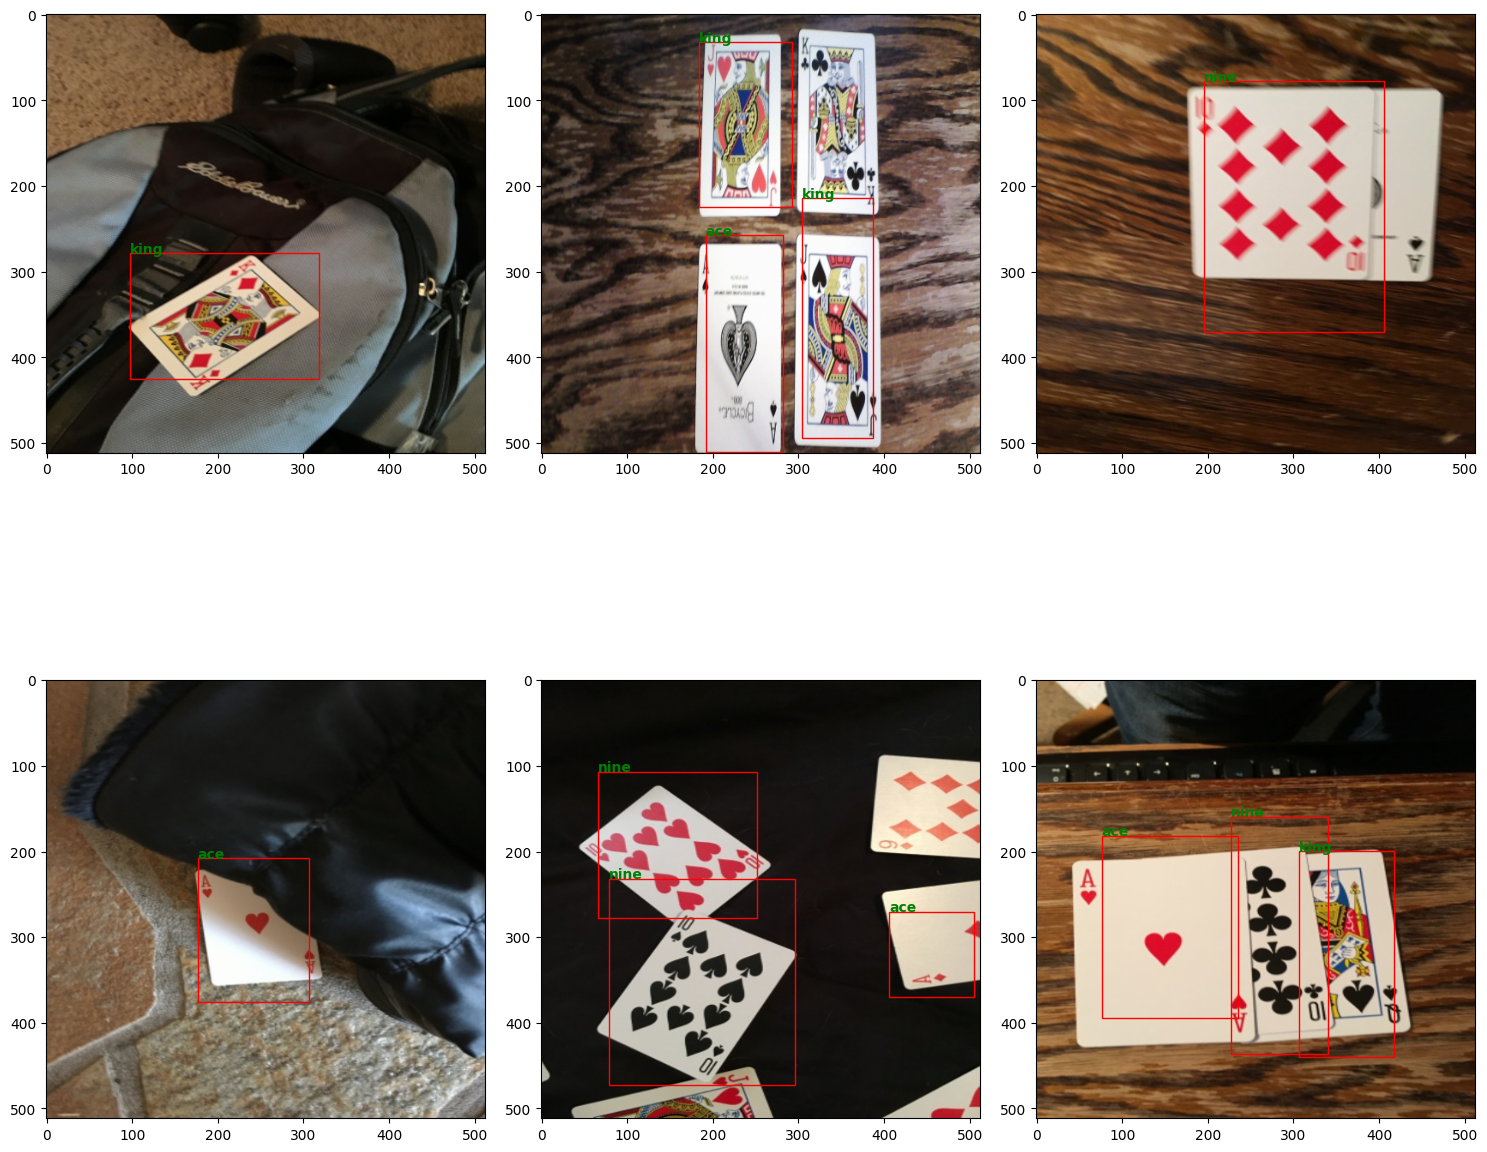

In [ ]:
# Не сработал visualize, чет впадлу стало его менять новый код написал по аналогии
classes = list(train_ds.class_dict_inv.values())
pred_cpu = pred.cpu()
num_cols = 3
num_rows = (pred_cpu.shape[0] + num_cols - 1) // num_cols
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i in range(pred_cpu.shape[0]):
    rectangles = decode_prediction(pred_cpu[i], threshold=0.9)

    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]

    image = batch['image'][i].permute(1, 2, 0).numpy()
    image = image * std + mean
    ax.imshow(image)

    for rectangle in rectangles:
        xmin, ymin, xmax, ymax, cls = rectangle['xmin'], rectangle['ymin'], rectangle['xmax'], rectangle['ymax'], rectangle['class']
        rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        ax.text(xmin, ymin, f"{classes[cls]}", color='green', weight = 'bold')

plt.tight_layout()
plt.show()



Результаты так себе, но работает хоть как-то - уже приятно. Сейчас попробуем с готовой архитектурой

# YOLOv8


In [ ]:
!pip install ultralytics

## Обработка данных

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [ ]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    lines = []
    for bbox in bboxes:
        xmin, ymin, xmax, ymax, cls = bbox
        cx = (xmin + xmax) / 2 / w_im
        cy = (ymin + ymax) / 2 / h_im
        w = (xmax - xmin) / w_im
        h = (ymax - ymin) / h_im

        line = f"{cls} {cx} {cy} {w} {h}"
        lines.append(line)

    return lines


In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
# Собираем YAML

nc =  len(train_ds.class_dict)
names = list(train_ds.class_dict_inv.values())

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Обучаем

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [ ]:
# import ultralytics
from ultralytics import YOLO

model = YOLO("yolov8n.yaml")  # build a new model from scratch
model.train(data="data.yaml", epochs=100)  # train the model


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 755k/755k [00:00<00:00, 14.5MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 76.8MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 2130.06it/s]

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels... 37 images, 0 backgrounds, 7 corrupt: 100%|██████████| 37/37 [00:00<00:00, 986.19it/s]

val: WARNING ⚠️ /content/valid/images/cam_image12.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2196]
val: WARNING ⚠️ /content/valid/images/cam_image16.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0952]
val: WARNING ⚠️ /content/valid/images/cam_image21.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1574]
val: WARNING ⚠️ /content/valid/images/cam_image23.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0622]
val: WARNING ⚠️ /content/valid/images/cam_image37.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.5013      1.5093]
val: WARNING ⚠️ /content/valid/images/cam_image38.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.7209      1.1534       1.713      1.1389]
val: WARNING ⚠️ /content/valid/images/cam_image6.jpg: ignoring corrupt image/label: non-normal

Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.91G      3.021      4.673      4.407         21        640: 100%|██████████| 21/21 [00:08<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

                   all         30         52   0.000741      0.105   0.000854   0.000179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.84G      2.951      4.348      4.097         18        640: 100%|██████████| 21/21 [00:07<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         30         52   0.000887      0.121   0.000622   0.000118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.84G      2.886      3.943       3.84         31        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         30         52   0.000747      0.121   0.000672   0.000119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.84G      2.849      3.675      3.601         27        640: 100%|██████████| 21/21 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         30         52    0.00082      0.133    0.00104   0.000158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.84G      2.777      3.551      3.408         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         30         52      0.771     0.0463     0.0505     0.0217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.84G      2.725      3.427      3.258         17        640: 100%|██████████| 21/21 [00:06<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         30         52      0.567      0.116     0.0619     0.0258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.84G      2.631      3.192      3.115         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         30         52      0.105      0.217      0.129     0.0588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.84G      2.437      3.069      2.989         24        640: 100%|██████████| 21/21 [00:06<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         30         52      0.253      0.169      0.171      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.84G      2.256      2.885      2.873         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         30         52      0.535       0.17      0.236      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.84G       2.16      2.756      2.753         24        640: 100%|██████████| 21/21 [00:08<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         30         52      0.235      0.218      0.241      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.82G      2.003      2.638      2.631         20        640: 100%|██████████| 21/21 [00:06<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         30         52      0.228      0.394      0.286      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.85G      1.937      2.611      2.553         18        640: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         30         52      0.422      0.579      0.481      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.84G      1.809      2.482       2.37         22        640: 100%|██████████| 21/21 [00:07<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         30         52      0.271      0.739      0.438      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.88G      1.816      2.465      2.378         15        640: 100%|██████████| 21/21 [00:05<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         30         52      0.458      0.556      0.445      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.85G      1.685      2.359      2.268         23        640: 100%|██████████| 21/21 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         30         52       0.34      0.523      0.442      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.85G       1.61      2.325      2.201         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         30         52      0.497      0.439      0.465      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.84G      1.573      2.204      2.145         15        640: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         30         52      0.349      0.676      0.448       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.85G       1.47      2.161      2.046         21        640: 100%|██████████| 21/21 [00:05<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         30         52       0.44      0.618      0.526      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.85G       1.42      2.137      1.992         15        640: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         30         52      0.436      0.577      0.488      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.85G      1.333      2.024      1.909         17        640: 100%|██████████| 21/21 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         30         52      0.454       0.69       0.55      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.84G      1.346       2.03      1.936         22        640: 100%|██████████| 21/21 [00:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         30         52      0.415      0.601      0.481      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.85G      1.306      1.946      1.855         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         30         52      0.438      0.652       0.55      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.85G      1.308       1.92      1.836         29        640: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all         30         52      0.359      0.708      0.472      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.85G      1.283      1.955      1.836         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         30         52       0.44      0.854      0.601      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.84G      1.234      1.865      1.786         23        640: 100%|██████████| 21/21 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         30         52      0.424      0.772      0.571      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.85G      1.196      1.782      1.756         22        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         30         52      0.552      0.708      0.598       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.85G        1.2      1.807      1.739         23        640: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all         30         52      0.508      0.718       0.66      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.82G      1.182      1.767      1.713         19        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         30         52       0.49      0.667      0.578      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.84G      1.174       1.75      1.698         14        640: 100%|██████████| 21/21 [00:07<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         30         52      0.489      0.779      0.646      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.84G      1.131      1.684      1.659         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         30         52      0.426      0.779      0.639      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.85G      1.086      1.662      1.623         26        640: 100%|██████████| 21/21 [00:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         30         52      0.481      0.745      0.589      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.85G      1.133      1.677      1.645         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         30         52      0.545      0.803      0.705      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.82G      1.084      1.615      1.606         28        640: 100%|██████████| 21/21 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         30         52      0.546      0.726      0.703      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.84G      1.075       1.62      1.598         28        640: 100%|██████████| 21/21 [00:05<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         30         52      0.642      0.737      0.736      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.85G       1.04      1.573      1.554         21        640: 100%|██████████| 21/21 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         30         52      0.514      0.797      0.657      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.84G      1.049      1.566       1.55         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         30         52      0.545      0.715        0.7      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.82G      1.012      1.511      1.524         16        640: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         30         52      0.622      0.634      0.701      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.85G       1.01      1.498      1.506         15        640: 100%|██████████| 21/21 [00:05<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         30         52      0.622      0.854      0.699      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.84G     0.9815      1.504      1.494         33        640: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         30         52      0.599      0.813       0.73      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.85G     0.9879      1.492      1.497         39        640: 100%|██████████| 21/21 [00:05<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         30         52      0.839      0.707      0.812      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.84G     0.9561      1.456      1.477         22        640: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         30         52       0.63      0.855      0.779      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.84G      0.934      1.432      1.456         38        640: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         30         52      0.559      0.804      0.717      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.85G     0.9427      1.426      1.473         16        640: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         30         52      0.634      0.793      0.748      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.85G      0.911      1.398      1.426         29        640: 100%|██████████| 21/21 [00:05<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         30         52      0.549      0.835      0.768      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.84G     0.9117      1.382      1.442         27        640: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         30         52      0.606      0.746       0.74      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.84G     0.9086      1.395      1.439         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         30         52      0.705      0.843      0.802      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.85G     0.9284      1.378      1.436         23        640: 100%|██████████| 21/21 [00:12<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         30         52       0.62       0.97      0.785       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.85G     0.9096      1.341      1.416         34        640: 100%|██████████| 21/21 [00:11<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         30         52      0.539      0.919      0.785       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.82G      0.872       1.31      1.401         27        640: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         30         52      0.668      0.826      0.817       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.85G     0.8938      1.304       1.42         21        640: 100%|██████████| 21/21 [00:07<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         30         52      0.773       0.75      0.752      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.84G     0.8971      1.311       1.42         28        640: 100%|██████████| 21/21 [00:08<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         30         52      0.631      0.853      0.839      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.84G     0.8922      1.255        1.4         26        640: 100%|██████████| 21/21 [00:08<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         30         52       0.67      0.828      0.839      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.84G     0.8703       1.31      1.381         15        640: 100%|██████████| 21/21 [00:07<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         30         52      0.638        0.7      0.785      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.85G     0.8704      1.284      1.405         28        640: 100%|██████████| 21/21 [00:06<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         30         52        0.7      0.794      0.814      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.84G     0.8286      1.222      1.362         22        640: 100%|██████████| 21/21 [00:09<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         30         52      0.603      0.748      0.758      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.85G      0.841      1.268      1.371         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         30         52      0.588      0.806      0.751      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.84G     0.8058      1.218      1.341         22        640: 100%|██████████| 21/21 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         30         52      0.734      0.881      0.903       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.84G     0.8302      1.199      1.357         34        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         30         52      0.572      0.943      0.805      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.85G     0.8431      1.222      1.354         28        640: 100%|██████████| 21/21 [00:07<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         30         52      0.566      0.915      0.768      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.82G     0.8067      1.181       1.32         17        640: 100%|██████████| 21/21 [00:06<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         30         52      0.624      0.929      0.829       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.82G     0.7955      1.172      1.334         32        640: 100%|██████████| 21/21 [00:07<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         30         52      0.796      0.793      0.898      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.85G      0.803      1.134      1.336         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         30         52      0.852      0.771      0.888      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.85G     0.8094      1.195       1.35         25        640: 100%|██████████| 21/21 [00:06<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all         30         52      0.687      0.855      0.884      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.85G     0.7902      1.132      1.313         18        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         30         52      0.732      0.735      0.815      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.85G     0.8171      1.175      1.345         20        640: 100%|██████████| 21/21 [00:06<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         30         52      0.788      0.825      0.888      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.84G     0.7802       1.11      1.302         38        640: 100%|██████████| 21/21 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         30         52      0.892      0.766      0.908      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.84G     0.8094      1.151      1.346         12        640: 100%|██████████| 21/21 [00:06<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         30         52      0.838      0.868      0.889       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.85G     0.7721      1.052      1.297         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         30         52      0.819      0.874      0.911       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.84G     0.7667      1.065      1.286         19        640: 100%|██████████| 21/21 [00:07<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         30         52      0.877        0.8      0.906       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.84G     0.7581      1.054      1.289         21        640: 100%|██████████| 21/21 [00:07<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         30         52      0.861      0.858      0.909      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.84G     0.7714      1.068      1.285         21        640: 100%|██████████| 21/21 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         30         52      0.732      0.825      0.878      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.85G     0.7651      1.041      1.297         15        640: 100%|██████████| 21/21 [00:06<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         30         52      0.842      0.835      0.908      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.85G     0.7682      1.069      1.303         16        640: 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         30         52      0.847      0.887       0.93      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.85G     0.7539      1.037      1.283         16        640: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         30         52      0.918      0.802       0.92      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.86G     0.7479      1.037      1.278         16        640: 100%|██████████| 21/21 [00:05<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         30         52      0.844      0.897      0.955      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.85G     0.7503      1.019      1.288         25        640: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         30         52      0.864      0.795      0.879      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.84G     0.7264      1.016      1.265         21        640: 100%|██████████| 21/21 [00:05<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         30         52      0.826       0.82      0.899      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.84G     0.7314     0.9967      1.268         21        640: 100%|██████████| 21/21 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         30         52      0.818      0.877      0.905      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.85G     0.7298      1.021      1.284         22        640: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         30         52      0.861      0.813      0.885      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.84G     0.7196      1.001      1.259         32        640: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         30         52      0.889      0.798      0.924      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.84G      0.719     0.9787      1.266         19        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         30         52      0.816      0.805       0.87      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.84G     0.7202     0.9794      1.258         19        640: 100%|██████████| 21/21 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         30         52      0.879       0.78      0.934      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.84G     0.7087     0.9796      1.242         16        640: 100%|██████████| 21/21 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         30         52      0.873      0.866      0.929      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.85G     0.7163     0.9691      1.261         20        640: 100%|██████████| 21/21 [00:07<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         30         52      0.849      0.864      0.932       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.84G     0.7199     0.9789      1.264         28        640: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         30         52       0.86      0.873      0.937      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.84G     0.6832     0.9269      1.224         24        640: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         30         52      0.922      0.871      0.961      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.85G     0.6803      0.934      1.223         22        640: 100%|██████████| 21/21 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         30         52      0.881      0.813      0.915       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.85G     0.6793     0.9296      1.217         13        640: 100%|██████████| 21/21 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         30         52      0.883      0.855       0.95      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.85G     0.6796     0.9081      1.224         19        640: 100%|██████████| 21/21 [00:05<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         30         52      0.906      0.916      0.964      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.84G     0.7194     0.9481      1.267         28        640: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         30         52       0.88      0.904      0.968       0.87


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.83G     0.5585     0.8078      1.098         15        640: 100%|██████████| 21/21 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         30         52      0.932      0.879      0.946      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.83G     0.5382     0.8063        1.1         11        640: 100%|██████████| 21/21 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         30         52      0.935      0.888      0.965      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.82G     0.5145      0.707      1.079         12        640: 100%|██████████| 21/21 [00:05<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         30         52       0.93        0.8      0.934      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.83G     0.5175     0.7312      1.064         11        640: 100%|██████████| 21/21 [00:06<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         30         52      0.905      0.922      0.957      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.83G     0.4943      0.708      1.047         10        640: 100%|██████████| 21/21 [00:05<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         30         52      0.917      0.883      0.945      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.83G     0.4945     0.7234      1.067         14        640: 100%|██████████| 21/21 [00:06<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         30         52      0.855      0.885      0.932      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.82G     0.5053     0.6944      1.061         14        640: 100%|██████████| 21/21 [00:05<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         30         52      0.904      0.911      0.951      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.82G     0.4892     0.6712      1.047         10        640: 100%|██████████| 21/21 [00:07<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         30         52      0.898      0.873      0.942      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.82G     0.4947     0.6799      1.057          8        640: 100%|██████████| 21/21 [00:05<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         30         52       0.91       0.83      0.949      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.82G     0.5058     0.6823       1.06          8        640: 100%|██████████| 21/21 [00:07<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         30         52      0.901      0.903      0.961      0.855



100 epochs completed in 0.224 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.226 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


                   all         30         52       0.88      0.904      0.968       0.87
                  king         30          8       0.75          1      0.995      0.978
                  jack         30          6          1      0.759      0.955      0.788
                   ace         30         12      0.898          1      0.983      0.892
                   ten         30         11      0.957      0.909      0.981      0.884
                  nine         30          9      0.857          1      0.995      0.898
                 queen         30          6      0.818      0.758      0.898      0.781
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a2bbbc52980>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

## Визуализируем

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.


image 1/1 /content/valid/images/IMG_2529.JPG: 640x480 1 ten, 14.1ms
Speed: 2.9ms preprocess, 14.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


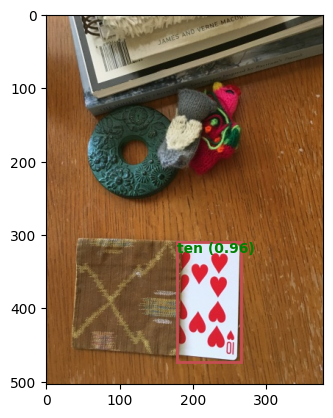


image 1/1 /content/valid/images/IMG_2386.JPG: 640x480 1 ace, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


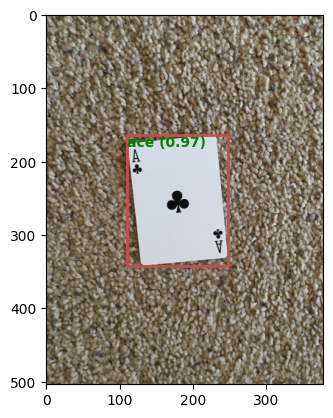


image 1/1 /content/valid/images/IMG_2677.JPG: 640x480 2 nines, 12.4ms
Speed: 3.0ms preprocess, 12.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)


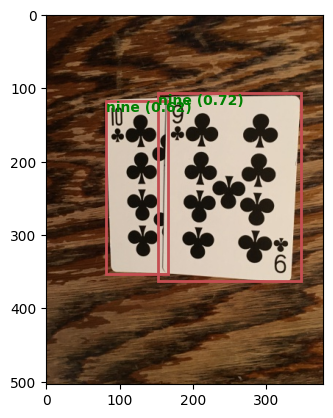


image 1/1 /content/valid/images/IMG_2647.JPG: 640x480 1 ace, 1 ten, 1 nine, 10.6ms
Speed: 3.4ms preprocess, 10.6ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 480)


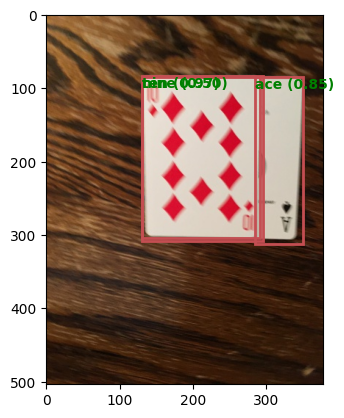


image 1/1 /content/valid/images/cam_image38.jpg: 384x640 1 king, 2 jacks, 1 ace, 97.5ms
Speed: 2.7ms preprocess, 97.5ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


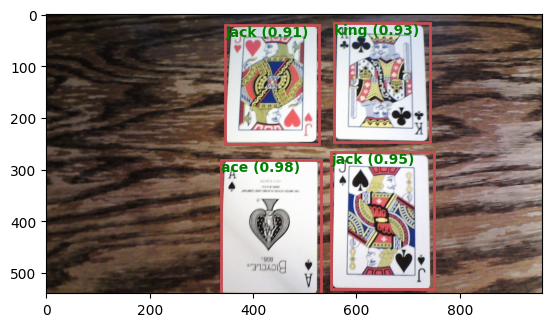


image 1/1 /content/valid/images/IMG_2474.JPG: 640x480 1 ace, 18.9ms
Speed: 2.8ms preprocess, 18.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)


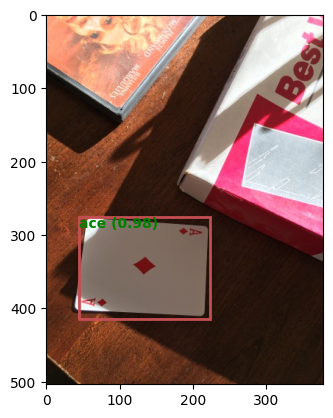


image 1/1 /content/valid/images/IMG_2526.JPG: 640x480 1 king, 1 queen, 16.1ms
Speed: 7.7ms preprocess, 16.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)


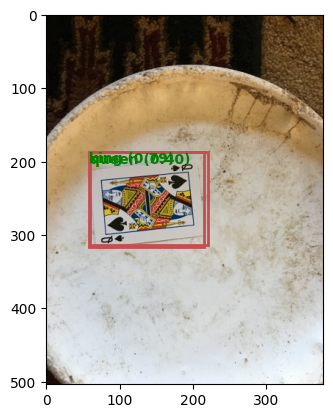


image 1/1 /content/valid/images/cam_image6.jpg: 384x640 4 nines, 20.4ms
Speed: 2.6ms preprocess, 20.4ms inference, 6.9ms postprocess per image at shape (1, 3, 384, 640)


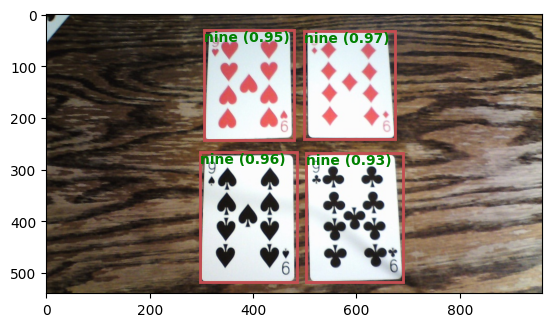


image 1/1 /content/valid/images/IMG_2587.JPG: 640x480 1 king, 2 aces, 1 nine, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


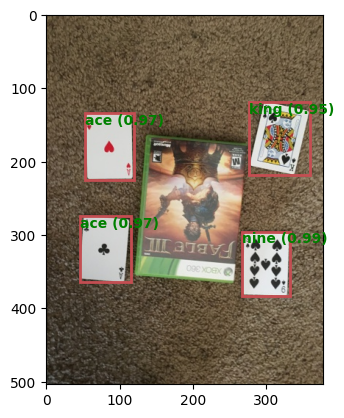


image 1/1 /content/valid/images/cam_image12.jpg: 384x640 1 king, 23.8ms
Speed: 2.9ms preprocess, 23.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


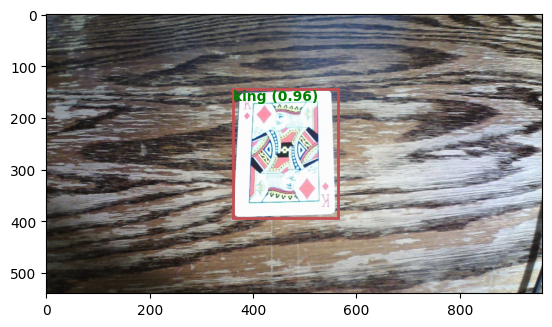

In [ ]:
import os

image_dir = "/content/valid/images"
image_files = os.listdir(image_dir)[:10]

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)

    results = model.predict(image_path)[0]

    image = results.orig_img[..., ::-1]  # был вывод BGR или че то такое надо было каналы поменять
    boxes = results.boxes.xyxy
    class_labels = results.names

    fig, ax = plt.subplots(1)
    ax.imshow(image)


    for i in range(len(boxes)):
        x_min, y_min, x_max, y_max = results.boxes.xyxy[i].tolist()
        class_idx = int(results.boxes.cls[i].item())
        class_name = class_labels[class_idx]

        rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        label = f"{class_name} ({float(results.boxes.conf[i].item()):.2f})"
        plt.text(x_min, y_min, label, color='green', verticalalignment='top', fontweight='bold')

    plt.show()


Все четко сработало